# Model of Grape

In [1]:
import tensorflow as tf

In [156]:
class Model(tf.Module):

    def __init__(self):
        
        #vars
        self.time = 100
        self.timesteps = 50
        
        
        # First, we define all ops and matrices (quantum mechanics)
        
        self.dim = 2 * 1 #2 qubits
        
        ##initial Vector
        zeroes = [0 for i in range(self.dim)]
        zeroes[0] = 1
        self.psi0 = tf.transpose(tf.cast(zeroes, dtype = tf.complex128))
        ##final vector
        zeroes = [0 for i in range(self.dim)]
        zeroes[1] =1 
        self.psi1 = tf.transpose(tf.cast(zeroes, dtype = tf.complex128))
        ##matrices
        #c = tf.constant(1/np.sqrt(2), dtype = tf.complex128)
        self.sigma_z = tf.linalg.normalize(
                            tf.cast([[1, 0],[0, -1]], dtype = tf.complex128)
                        )[0]   # the second element is a unwanted scalar
        self.sigma_x = tf.linalg.normalize(
                            tf.cast([[0, 1],[1, 0]], dtype = tf.complex128)
                        )[0]
        
        self.identity = tf.linalg.normalize(
                            tf.cast([[1, 0],[0, 1]], dtype = tf.complex128)
                        )[0] 
        
        self.hams = [self.sigma_z,
                     self.sigma_x]
        self.num_drives = len(self.hams)# -1 # -1 for time indep
        self.total_time = self.time
        self.dt = tf.cast(self.total_time/self.timesteps, dtype = tf.complex128)
        
        
        
        # Second, Randomly generate weight and bias terms
        rand_init = tf.random.uniform(shape=[self.num_drives, self.timesteps], minval=0., maxval=5., seed=22)
        rand_init = tf.cast(rand_init, dtype = tf.complex128)
        # Initialize model parameters
        '''
        Structure of u list:  [u11, u12, u13] #drive 1
                              [u12, u22, u23] #drive 2...
        '''
        self.us_list = [[tf.Variable(rand_init[i][j], dtype = tf.complex128) for j in range(self.timesteps)] for i in range(self.num_drives)]
        
        
        
   # @tf.function
    def __call__(self):
        # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
        #return self.w_q * (x**2) + self.w_l * x + self.b
        unitary = self.time_evol_op()
        #print(unitary.numpy())
        final_state = self.prod_matrix_state(unitary, self.psi0)
        #print('...')
        #tf.print(final_state, [final_state])
        #return tf.square(self.inner_product(final_state, self.psi1))
        norm = tf.math.abs(self.inner_product(final_state, self.psi1))
        return tf.square(norm)

    #@tf.function
    def time_evol_op(self):
        '''
        returns e^{-iHt}
        '''
        imag = tf.constant(-1j, dtype=tf.complex128, shape=None, name='Const')
        unitary = self.identity #start of identity
        for j in range(self.timesteps): 
            for i in range(self.num_drives):
                unitary = tf.matmul(self.identity - (imag*self.us_list[i][j]*self.hams[i]*self.dt), unitary) # e^-A \approx 1 - A
        unitary = tf.linalg.normalize(unitary)[0]
        return unitary
    
    #@tf.function
    def prod_matrix_state(self, unitary, state): 
        '''
        Multiply matrix by statevector
        '''
        #print(tf.linalg.matvec(unitary, state))
        state = tf.linalg.matvec(unitary, state)
        #state = tf.ensure_shape(state, [2,1])
        #print(state.numpy())
        return state
    
   # @tf.function    
    def inner_product(self, psi1, psi2):
        # Take 2 states psi1,psi2, calculate their overlap, for single vector
        
        norm = tf.cast(0, dtype = tf.complex128)
        for i in range(len(psi1)): 
            norm = tf.add(norm, 
                          tf.multiply(tf.math.conj(psi1[i]), psi2[i]))
        return norm
    
    #@tf.function
    def kron_product(self, mat1, mat2):
        '''
        Takes kronecker product of 2 matrices
        '''
        operator_1 = tf.linalg.LinearOperatorFullMatrix(mat1.numpy())
        operator_2 = tf.linalg.LinearOperatorFullMatrix(mat2.numpy())
        operator = tf.linalg.LinearOperatorKronecker([operator_1, operator_2])
        return tf.cast(operator.to_dense().numpy(), dtype = tf.complex64)
#     def hamiltonian(self):
#         '''
#         return the drive hamiltonains
#         '''
        
                                       

In [150]:
#sigma_z = tf.cast([[1, 0],[0, -1]], dtype = tf.complex128)

In [157]:
#quad_model.sigma_z

In [158]:
# #normalized
# tf.linalg.normalize(
#     sigma_z, ord='euclidean', axis=None, name=None
# )[0]

In [159]:
# zeroes = [0 for i in range(2)]
# zeroes[0] = 1
# psi0 = tf.transpose(tf.cast(zeroes, dtype = tf.complex128))
# zeroes = [0 for i in range(2)]
# zeroes[0] = 1
# psi1 = tf.transpose(tf.cast(zeroes, dtype = tf.complex128))
#quad_model = Model()
# quad_model.inner_product(psi0, psi1)

In [160]:
#quad_model.variables

In [161]:
#quad_model()

In [162]:
# loss
#@tf.function
def err_loss(y):
    return 1-y

In [163]:
import matplotlib.pyplot as plt

Mean squared error for step 0: 0.914
Mean squared error for step 10: 0.011
Mean squared error for step 20: 0.004
Mean squared error for step 30: 0.002
Mean squared error for step 40: 0.002
Mean squared error for step 50: 0.001
Mean squared error for step 60: 0.001
Mean squared error for step 70: 0.001
Mean squared error for step 80: 0.001
Mean squared error for step 90: 0.001


time took: 17.373496532440186 seconds


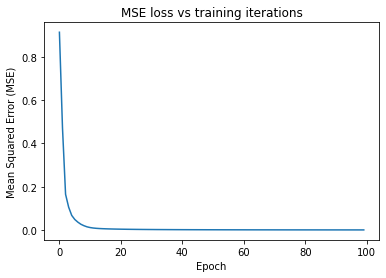

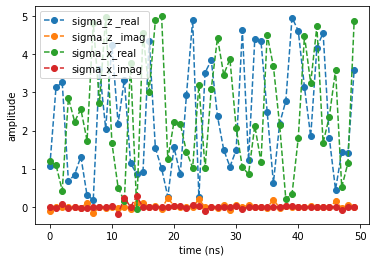

In [165]:
#timing
import time
t0 = time.time()
# Set training parameters
epochs = 100
learning_rate = 0.1
losses = [] 



quad_model = Model()
# Format training loop
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        iter_loss = err_loss(quad_model())

    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(iter_loss, quad_model.variables)
    #print(grads)
    for g,v in zip(grads, quad_model.variables):
        #print(v)
        v.assign_sub(learning_rate*g)
        #print(v)
      # Keep track of model loss per epoch
    loss = err_loss(quad_model())
    losses.append(loss)
    #print(quad_model.variables)
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')
    

print('time took: {} seconds'.format(time.time() - t0))

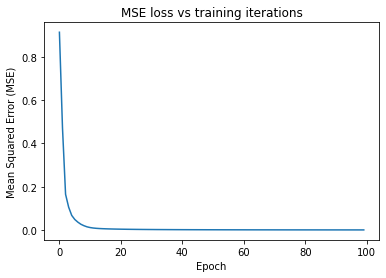

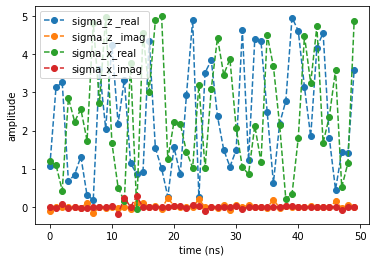

In [166]:
# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');


# Plot drives
fig = plt.figure()
listy = tf.convert_to_tensor(quad_model.us_list).numpy()
labels = ['sigma_z ', 'sigma_x']
for i in range(2):
    plt.plot(np.real(listy[i]), marker = 'o', linestyle = '--', label = labels[i] + '_real')
    plt.plot(np.imag(listy[i]), marker = 'o', linestyle = '--', label = labels[i] + '_imag')
plt.xlabel('time (ns)')
plt.ylabel('amplitude')
plt.legend()
    

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[ 2.37140488e+00-1.66320734e-01j,  7.29120621e-13-3.33333333e-01j],
       [-9.38093306e-14+5.37867896e-14j,  3.06769068e+00-9.03422743e-03j]])>

In [136]:
def plot_drives():
    '''
    plot us_list in the model
    '''
    listy = tf.convert_to_tensor(quad_model.us_list).numpy()

    
    return drives

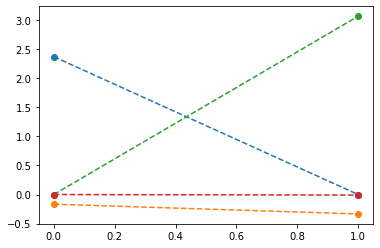